# Bulge data

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.display as afwDisplay
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig
from lsst.meas.algorithms import SourceDetectionTask, SourceDetectionConfig
from lsst.meas.deblender               import SourceDeblendTask, SourceDeblendConfig
from lsst.meas.base                    import SingleFrameMeasurementTask, SingleFrameMeasurementConfig
from lsst.meas.base import NoiseReplacer, NoiseReplacerConfig
import matplotlib
import matplotlib.animation as animation
from matplotlib.colors import LogNorm
from IPython.display import IFrame, display, Markdown, HTML
import lsst.meas.extensions.photometryKron
import lsst.geom as lsstGeom

afwDisplay.setDefaultBackend('matplotlib') 


In [2]:
matplotlib.rcParams["figure.figsize"] = (8, 8)
matplotlib.rcParams["font.size"] = 12
matplotlib.rcParams["figure.dpi"] = 600

In [3]:
REPO = '/project/shared/decamBulge/saha2/rerun/processed_data'  
butler = dafPersist.Butler(REPO)

In [4]:
metadata = butler.queryMetadata('calexp',['visit','ccd','filter'])
for dataset in metadata:
    dataId = {'visit': int(dataset[0]), 'ccd': int(dataset[1]), 'filter':dataset[2]}
    if butler.datasetExists('src', dataId=dataId):
        print(dataId)


{'visit': 210597, 'ccd': 30, 'filter': 'g'}
{'visit': 210597, 'ccd': 36, 'filter': 'g'}
{'visit': 210597, 'ccd': 37, 'filter': 'g'}
{'visit': 210597, 'ccd': 48, 'filter': 'g'}
{'visit': 210597, 'ccd': 53, 'filter': 'g'}
{'visit': 210597, 'ccd': 55, 'filter': 'g'}
{'visit': 210597, 'ccd': 56, 'filter': 'g'}
{'visit': 210597, 'ccd': 57, 'filter': 'g'}
{'visit': 210597, 'ccd': 58, 'filter': 'g'}
{'visit': 210597, 'ccd': 60, 'filter': 'g'}
{'visit': 210597, 'ccd': 62, 'filter': 'g'}


In [5]:
VISIT = 210597
CCD = 30
calexp = butler.get('calexp', visit=int(VISIT), ccd=CCD)

In [6]:
#Set up the task, it requires a config when we instantiate it
charConfig = CharacterizeImageConfig()
charImageTask = CharacterizeImageTask(None, config=charConfig)
#run the task on our exposure and save the output. This takes a minute to run 
charResult = charImageTask.run(calexp)

In [7]:
charResult.sourceCat.asAstropy()

id,coord_ra,coord_dec,parent,calib_psf_candidate,calib_psf_used,calib_psf_reserved,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_CircularApertureFlux_flag_badCentroid_badError,base_GaussianFlux_flag_badCentroid_badError,base_PsfFlux_flag_badCentroid_badError,base_SdssShape_flag_badCentroid_badError,slot_Centroid_flag_badError,base_SdssShape_xx,slot_Shape_xx,base_SdssShape_yy,slot_Shape_yy,base_SdssShape_xy,slot_Shape_xy,base_SdssShape_xxErr,slot_Shape_xxErr,base_SdssShape_yyErr,slot_Shape_yyErr,base_SdssShape_xyErr,slot_Shape_xyErr,base_SdssShape_x,slot_Shape_x,base_SdssShape_y,slot_Shape_y,base_SdssShape_instFlux,slot_Shape_instFlux,base_SdssShape_instFluxErr,slot_Shape_instFluxErr,base_SdssShape_psf_xx,slot_PsfShape_xx,slot_Shape_psf_xx,base_SdssShape_psf_yy,slot_PsfShape_yy,slot_Shape_psf_yy,base_SdssShape_psf_xy,slot_PsfShape_xy,slot_Shape_psf_xy,base_SdssShape_instFlux_xx_Cov,slot_Shape_instFlux_xx_Cov,base_SdssShape_instFlux_yy_Cov,slot_Shape_instFlux_yy_Cov,base_SdssShape_instFlux_xy_Cov,slot_Shape_instFlux_xy_Cov,base_SdssShape_flag,base_GaussianFlux_flag_badShape,slot_Shape_flag,base_SdssShape_flag_unweightedBad,base_GaussianFlux_flag_badShape_unweightedBad,slot_Shape_flag_unweightedBad,base_SdssShape_flag_unweighted,base_GaussianFlux_flag_badShape_unweighted,slot_Shape_flag_unweighted,base_SdssShape_flag_shift,base_GaussianFlux_flag_badShape_shift,slot_Shape_flag_shift,base_SdssShape_flag_maxIter,base_GaussianFlux_flag_badShape_maxIter,slot_Shape_flag_maxIter,base_SdssShape_flag_psf,base_GaussianFlux_flag_badShape_psf,slot_Shape_flag_psf,base_CircularApertureFlux_3_0_instFlux,base_CircularApertureFlux_3_0_instFluxErr,base_CircularApertureFlux_3_0_flag,base_CircularApertureFlux_3_0_flag_apertureTruncated,base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_4_5_instFlux,base_CircularApertureFlux_4_5_instFluxErr,base_CircularApertureFlux_4_5_flag,base_CircularApertureFlux_4_5_flag_apertureTruncated,base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,base_CircularApertureFlux_6_0_instFlux,base_CircularApertureFlux_6_0_instFluxErr,base_CircularApertureFlux_6_0_flag,base_CircularApertureFlux_6_0_flag_apertureTruncated,base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_9_0_instFlux,base_CircularApertureFlux_9_0_in

Text(0.5, 0, 'Magnitude')

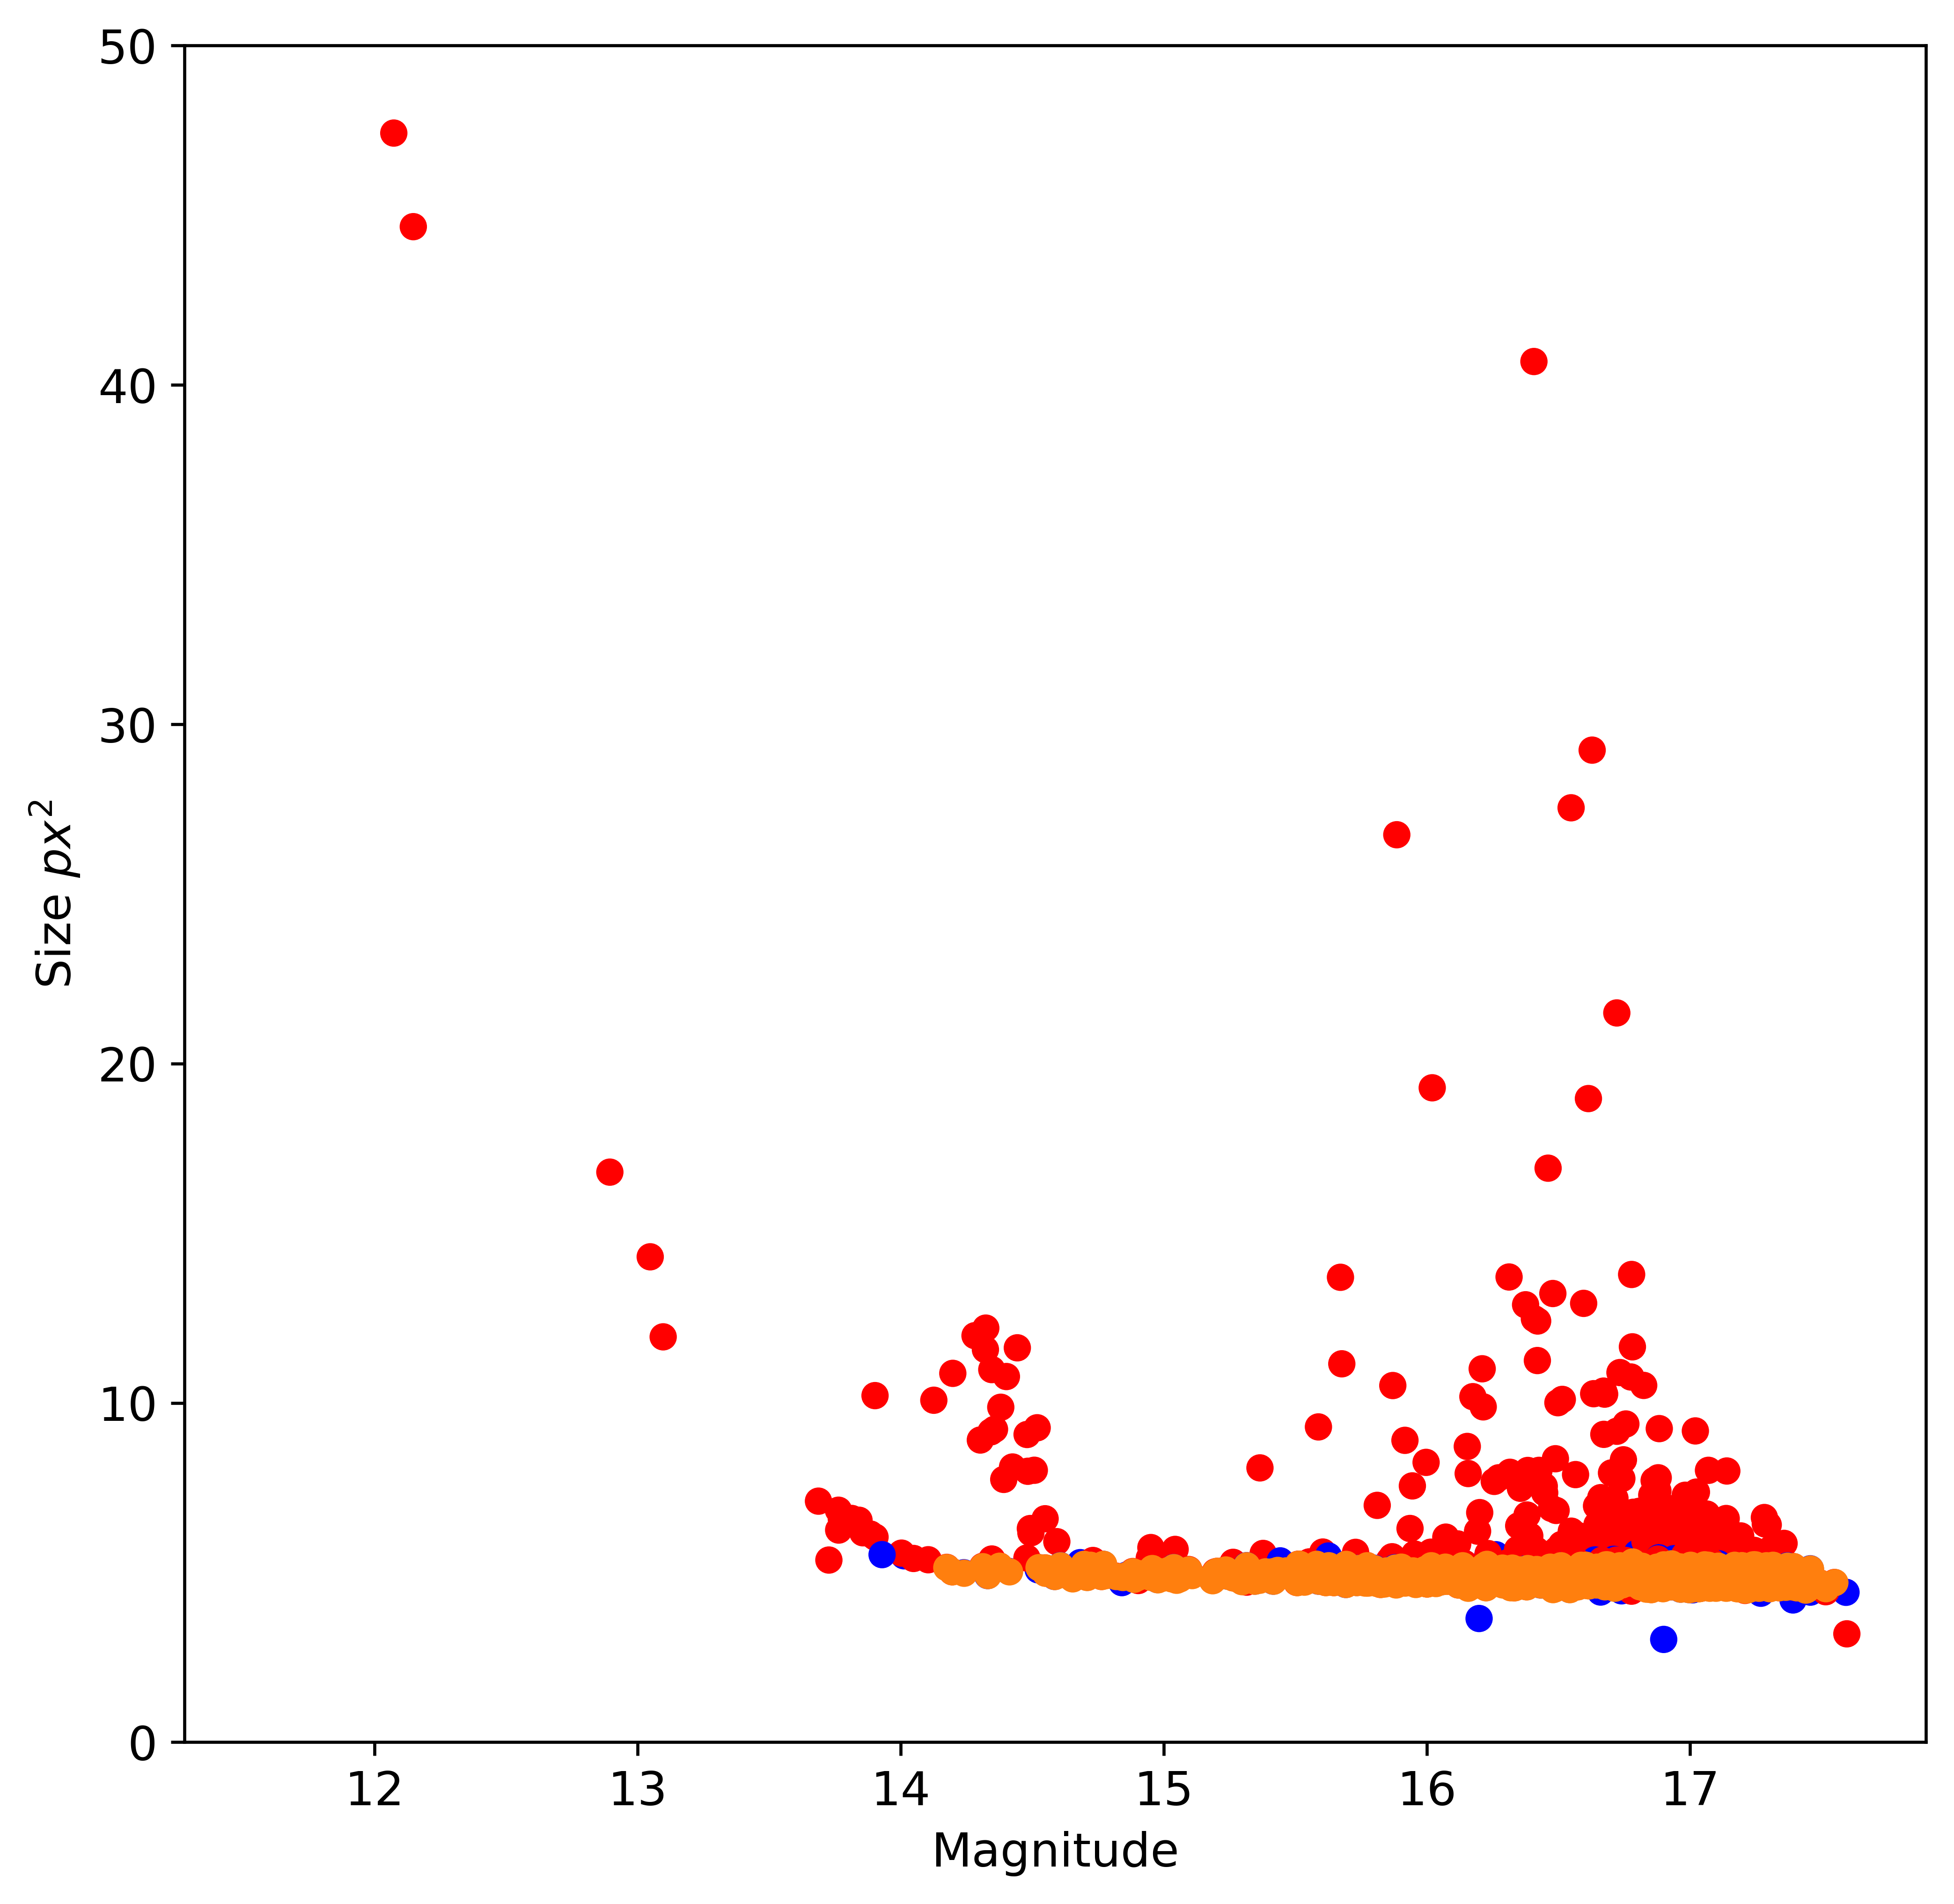

In [8]:
# calculate the magnitude and magnitude error for sources
# we grab the photoCalib from the calexp, and use its instFluxToMagnitude method
# instFluxToMagnitude can return a vector of magnitude and magnitude errors if you pass in
# your source catalog and the name of the flux measurement algorithm you want to use
apMag = calexp.getPhotoCalib().instFluxToMagnitude(charResult.sourceCat,'base_CircularApertureFlux_12_0')
# use the sloan algorithm to calculate something like a size
# this is just one definition of size, and the size reported here in pix^2 is not the area of the object
size = charResult.sourceCat['base_SdssShape_xx'] + charResult.sourceCat['base_SdssShape_yy']
# mask if it was not a PSF candidate
calib_mask = charResult.sourceCat['calib_psf_candidate']

plt.figure(1)
# color the points by their extendendness, it will be red for resolved sources and blue for point sources
plt.scatter(apMag[:,0], size, c=charResult.sourceCat['base_ClassificationExtendedness_value'],
           cmap='bwr')
# over plot PSF candidates in orange
# to get the magnitues we just need the first column from apMag
# the second column would give you magnitude errors
plt.scatter(apMag[:,0][calib_mask], size[calib_mask], color='C1')
plt.ylim([0,50])
plt.ylabel('Size $px^2$')
plt.xlabel('Magnitude')

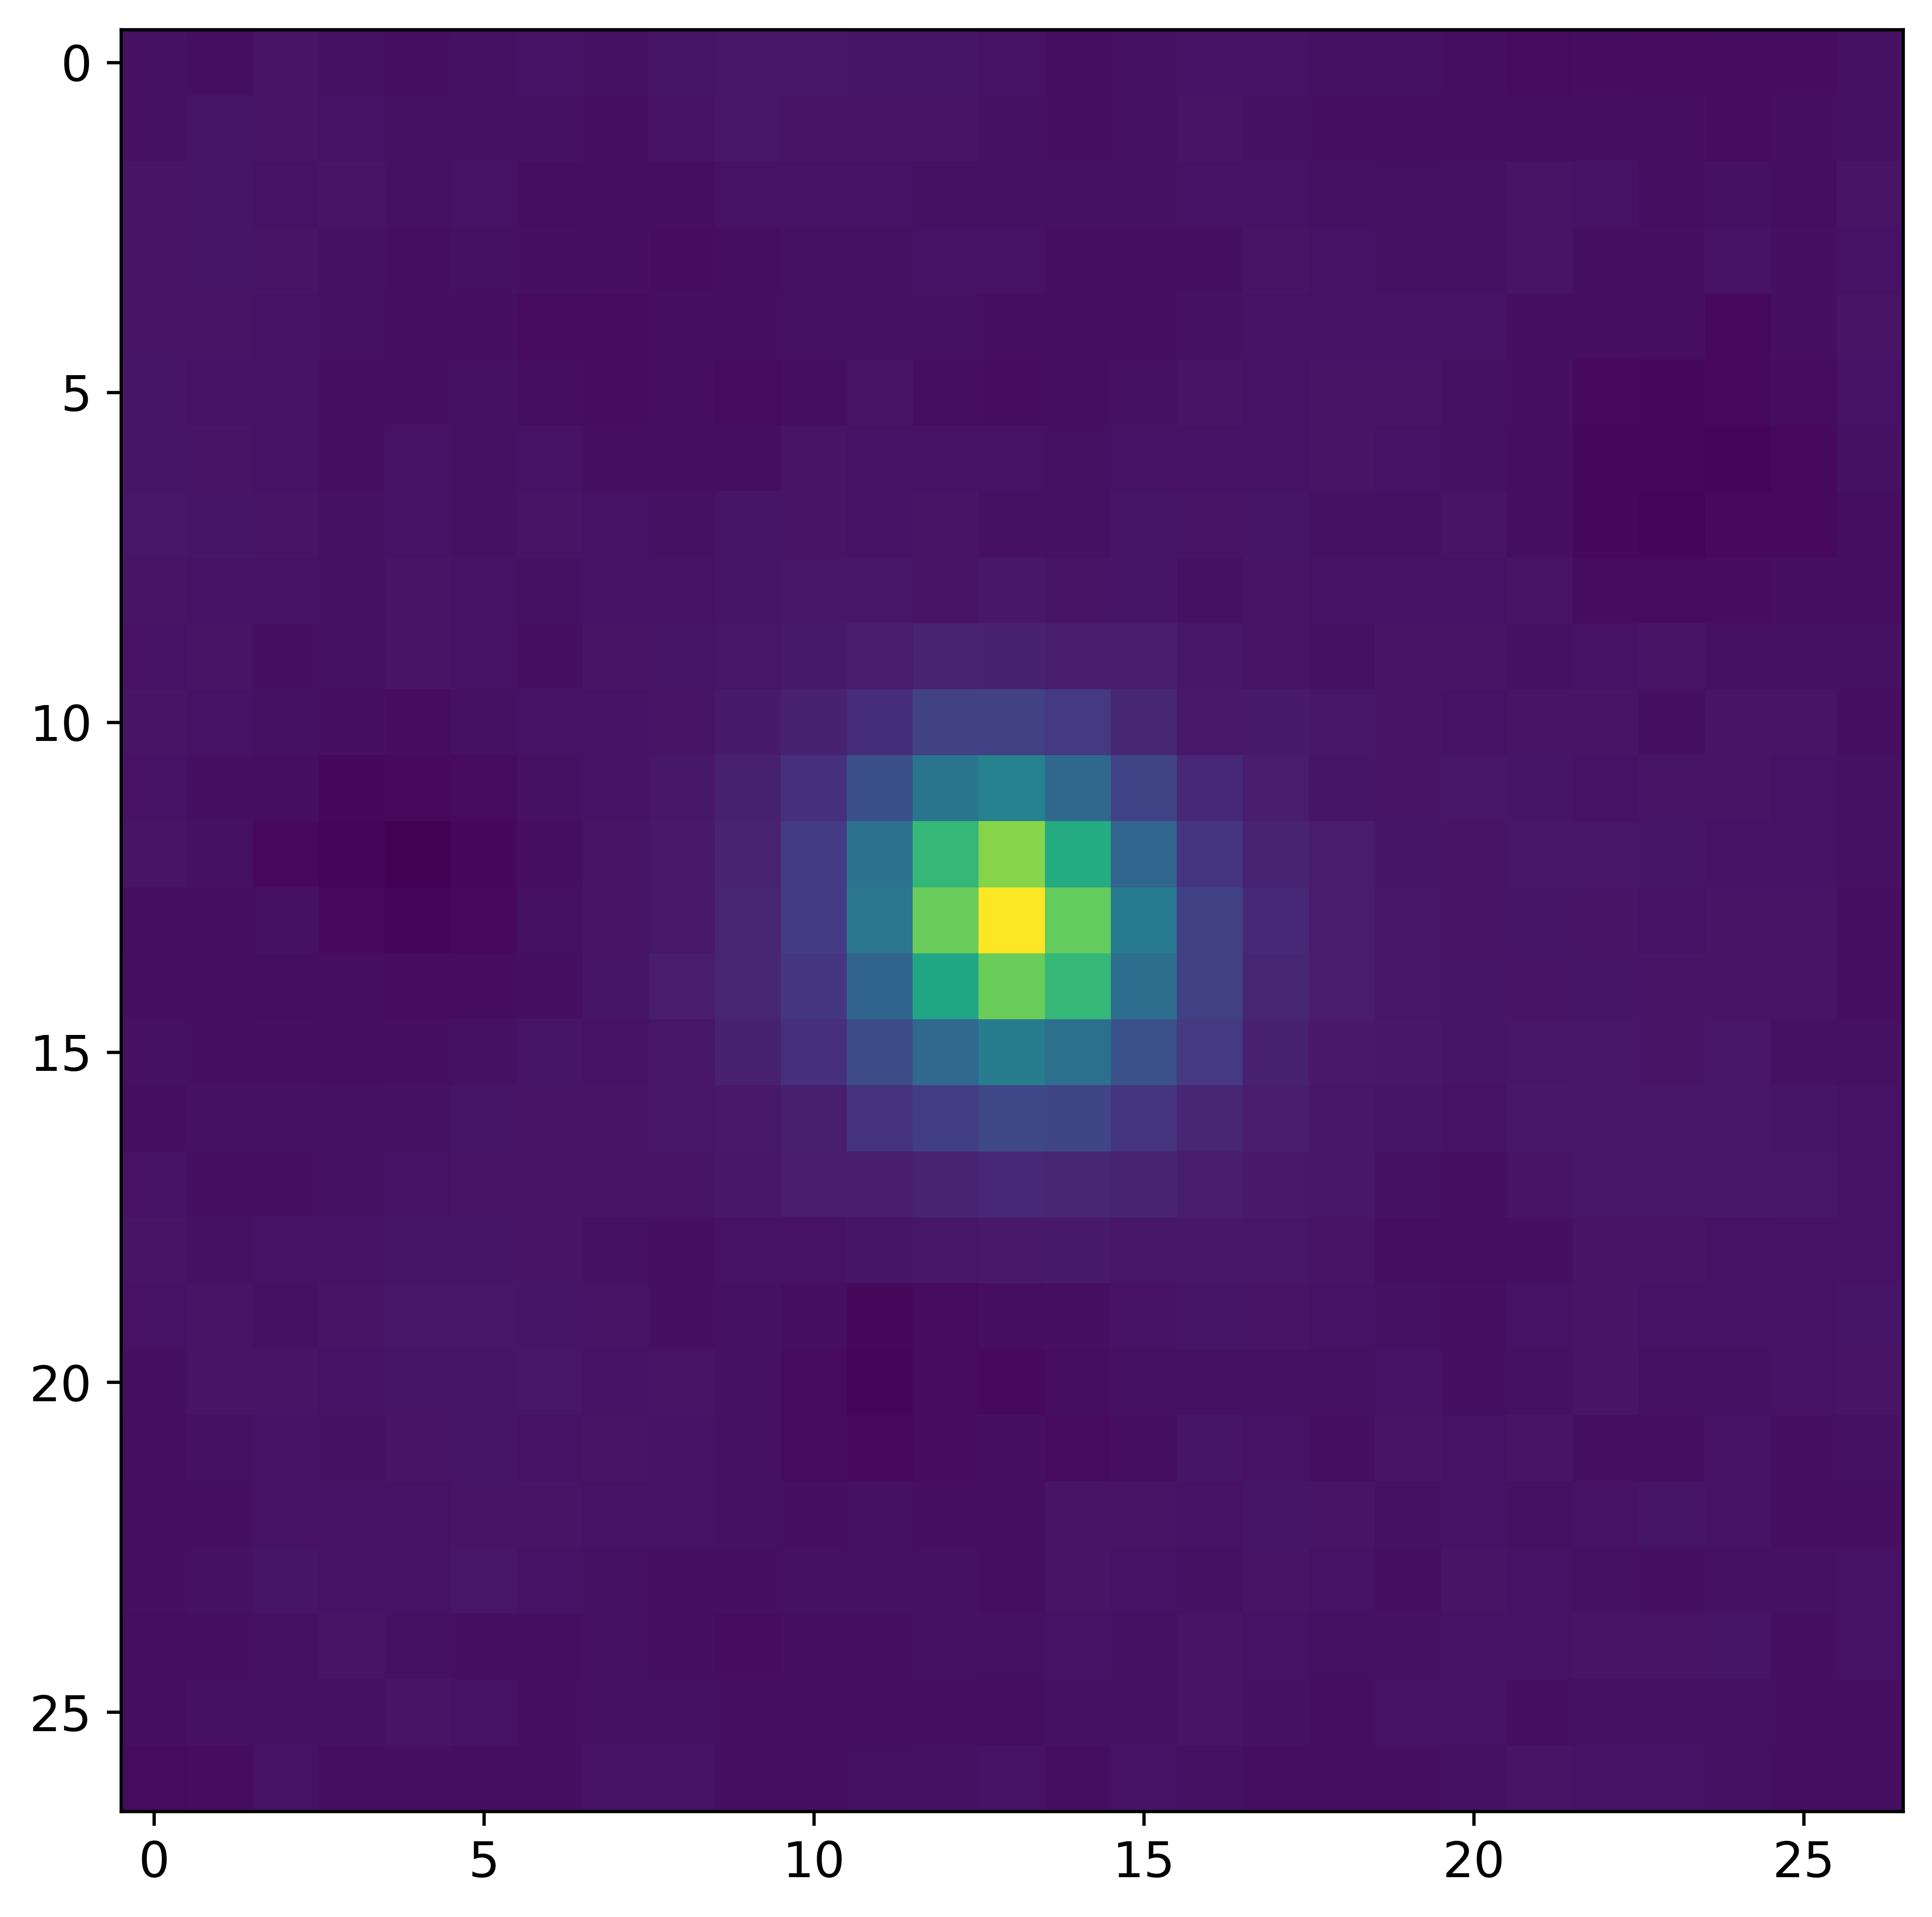

In [9]:
myPoint = lsstGeom.Point2D(400,500)
myPsf = calexp.getPsf().computeImage(myPoint)
plt.figure(2)
plt.imshow(myPsf.getArray())

In [10]:
# setup a mask to give us stars that were PSF candidates but ultimately not used for PSF estimation
calib_not_used = np.logical_and.reduce([charResult.sourceCat['calib_psf_candidate'],
                                        ~charResult.sourceCat['calib_psf_used'],
                                        charResult.sourceCat['base_PixelFlags_flag_saturatedCenter'] == 0])
# grab the cadidate-but-not-used stars
reserve_sources = charResult.sourceCat[calib_not_used]

<Figure size 4800x4800 with 0 Axes>

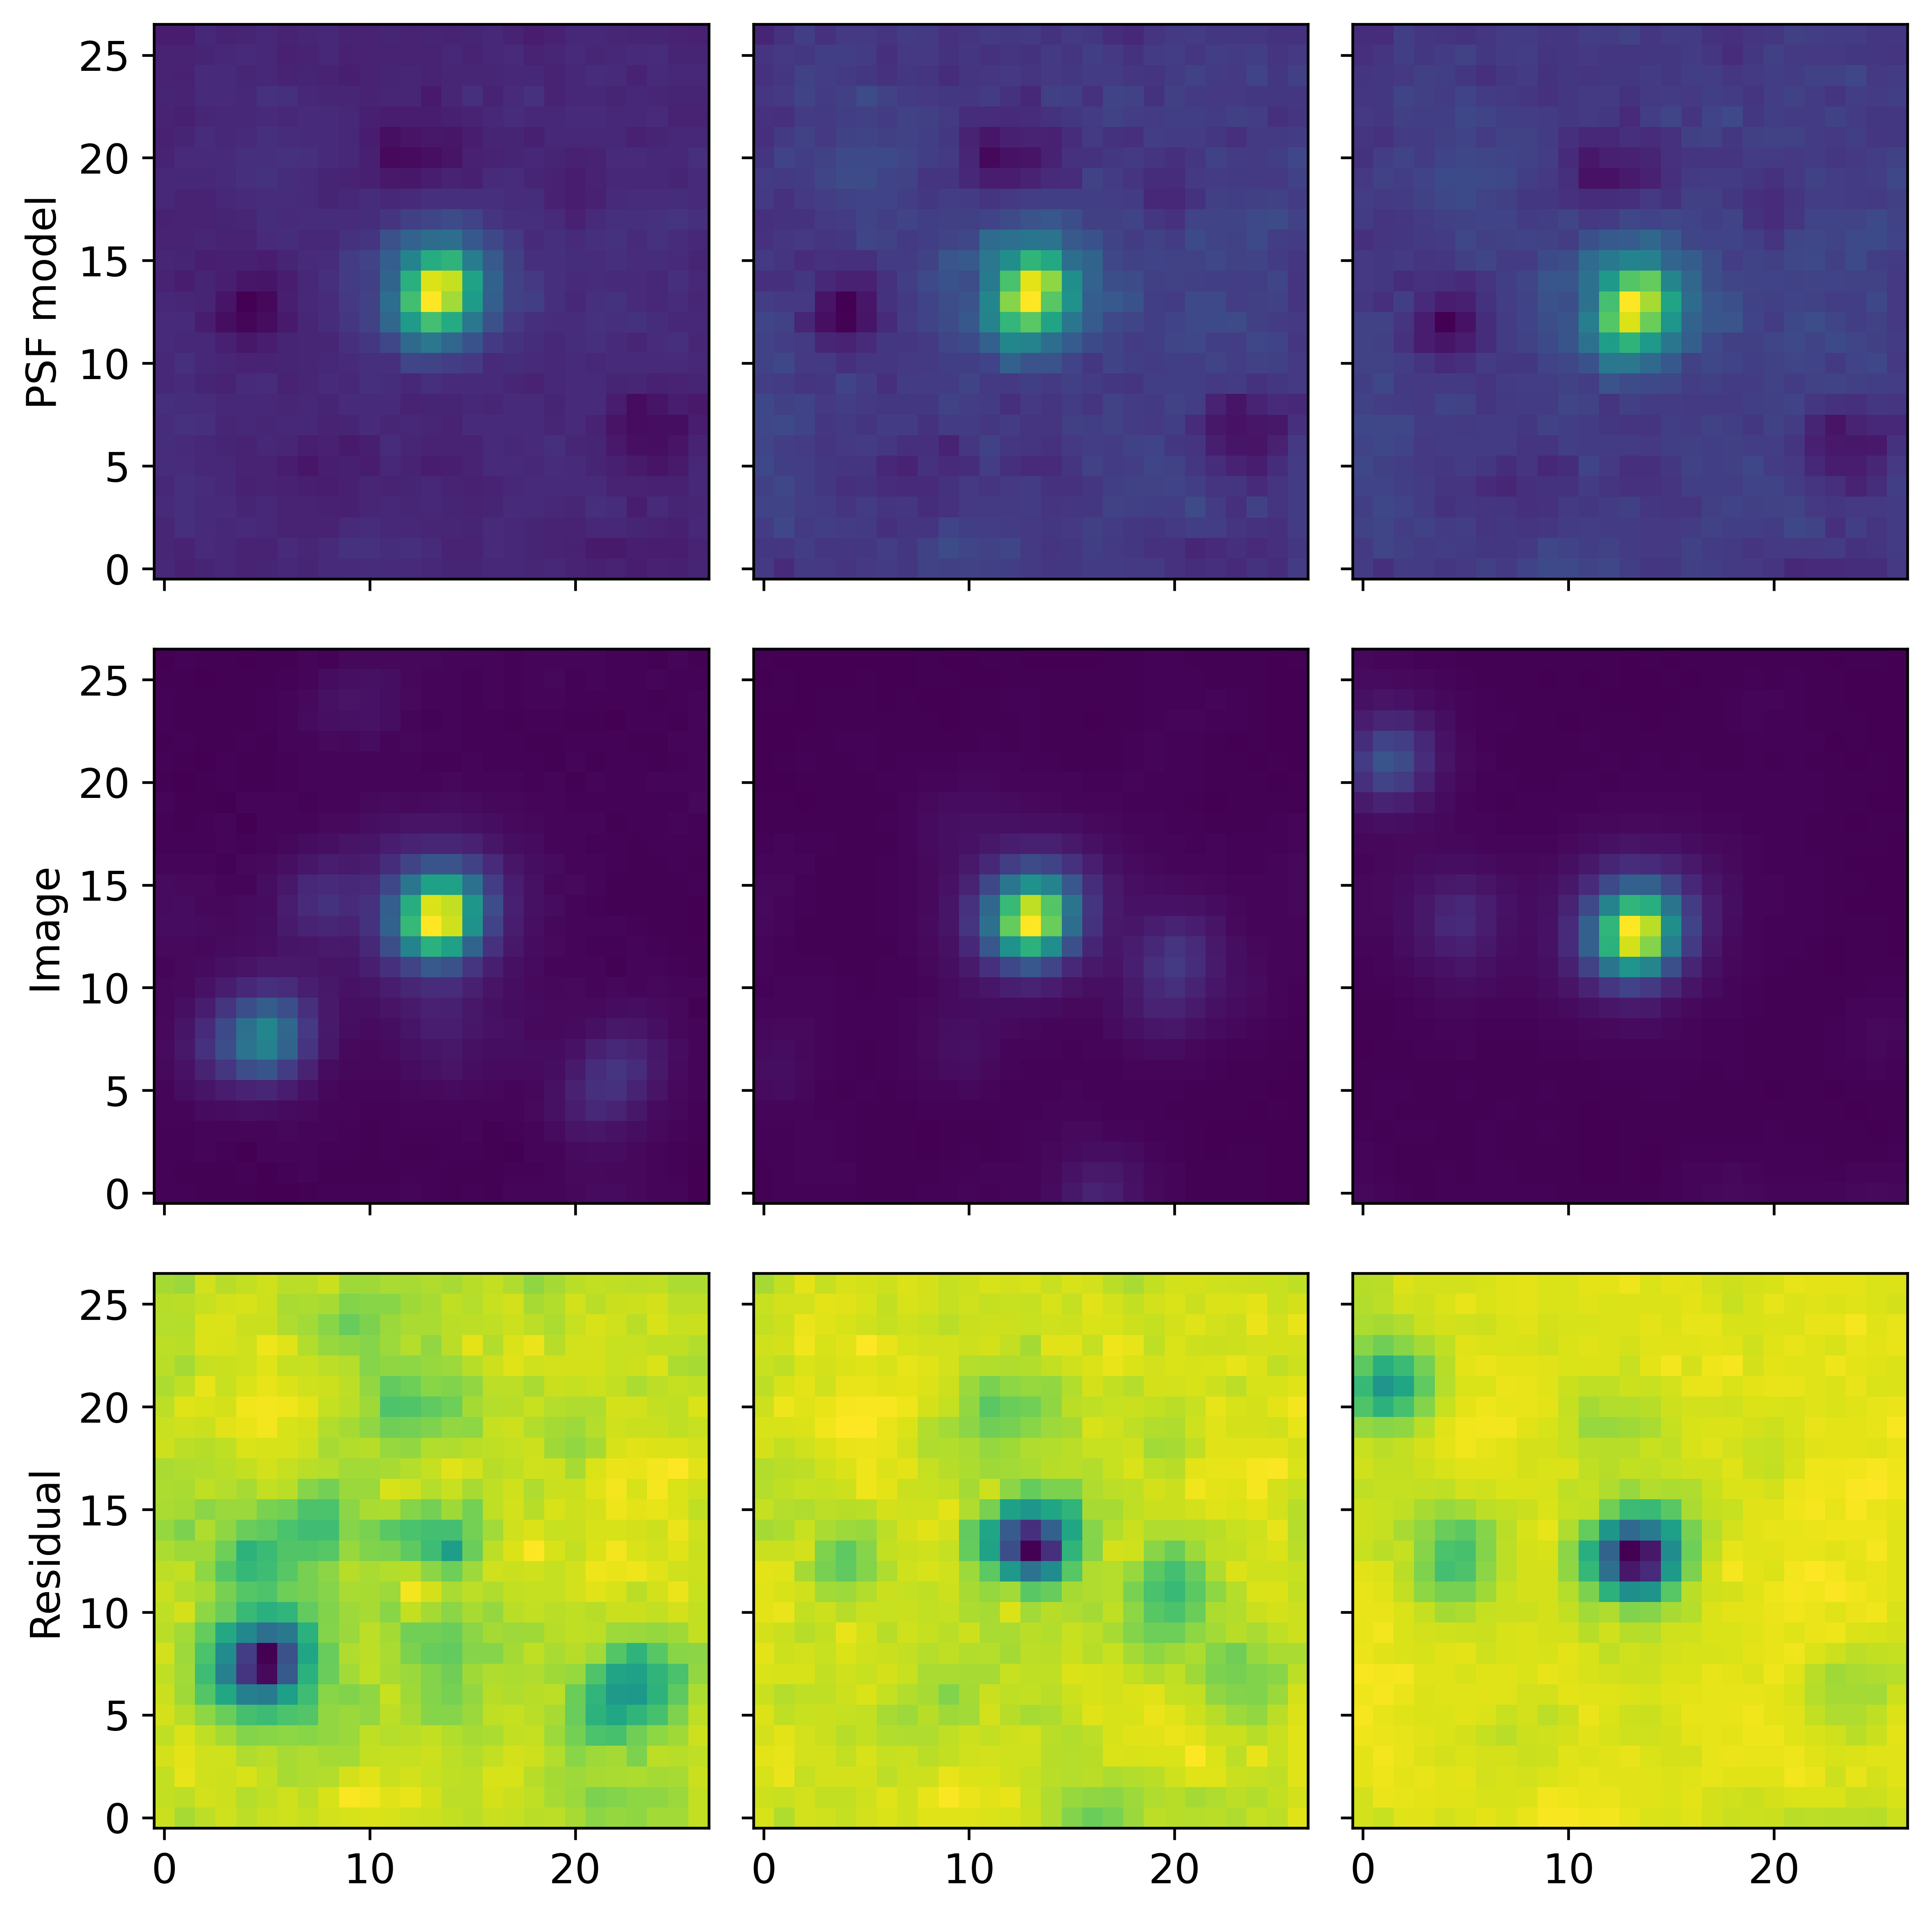

In [11]:
residuals = calexp.maskedImage.getImage()
psf = calexp.getPsf()

plt.figure(3)

f, ax = plt.subplots(ncols=3, nrows=3, sharex=True, sharey=True)
for i in (0,1,2):
    # we can evaluate the PSF at different locations on the CCD
    # lets evaluate it at the location of our reserve sources
    psfImage = psf.computeImage(reserve_sources[i+800].getCentroid()).convertF()
    # we should scale up the modle PSF so its flux matches that of the star we will compare it too
    psfImage *= reserve_sources[i].getPsfInstFlux()/np.sum(psfImage.getArray())
    ax[0,i].imshow(psfImage.getArray(), origin='lower') #plot the model PSF
    ax[1,i].imshow(residuals[psfImage.getBBox()].getArray(), origin='lower') #plot the star
    ax[2,i].imshow(psfImage.getArray() - residuals[psfImage.getBBox()].getArray(), origin='lower') #plot residuals

ax[0,0].set_ylabel('PSF model')
ax[1,0].set_ylabel('Image')
ax[2,0].set_ylabel('Residual')
plt.tight_layout()

<Figure size 4800x4800 with 0 Axes>

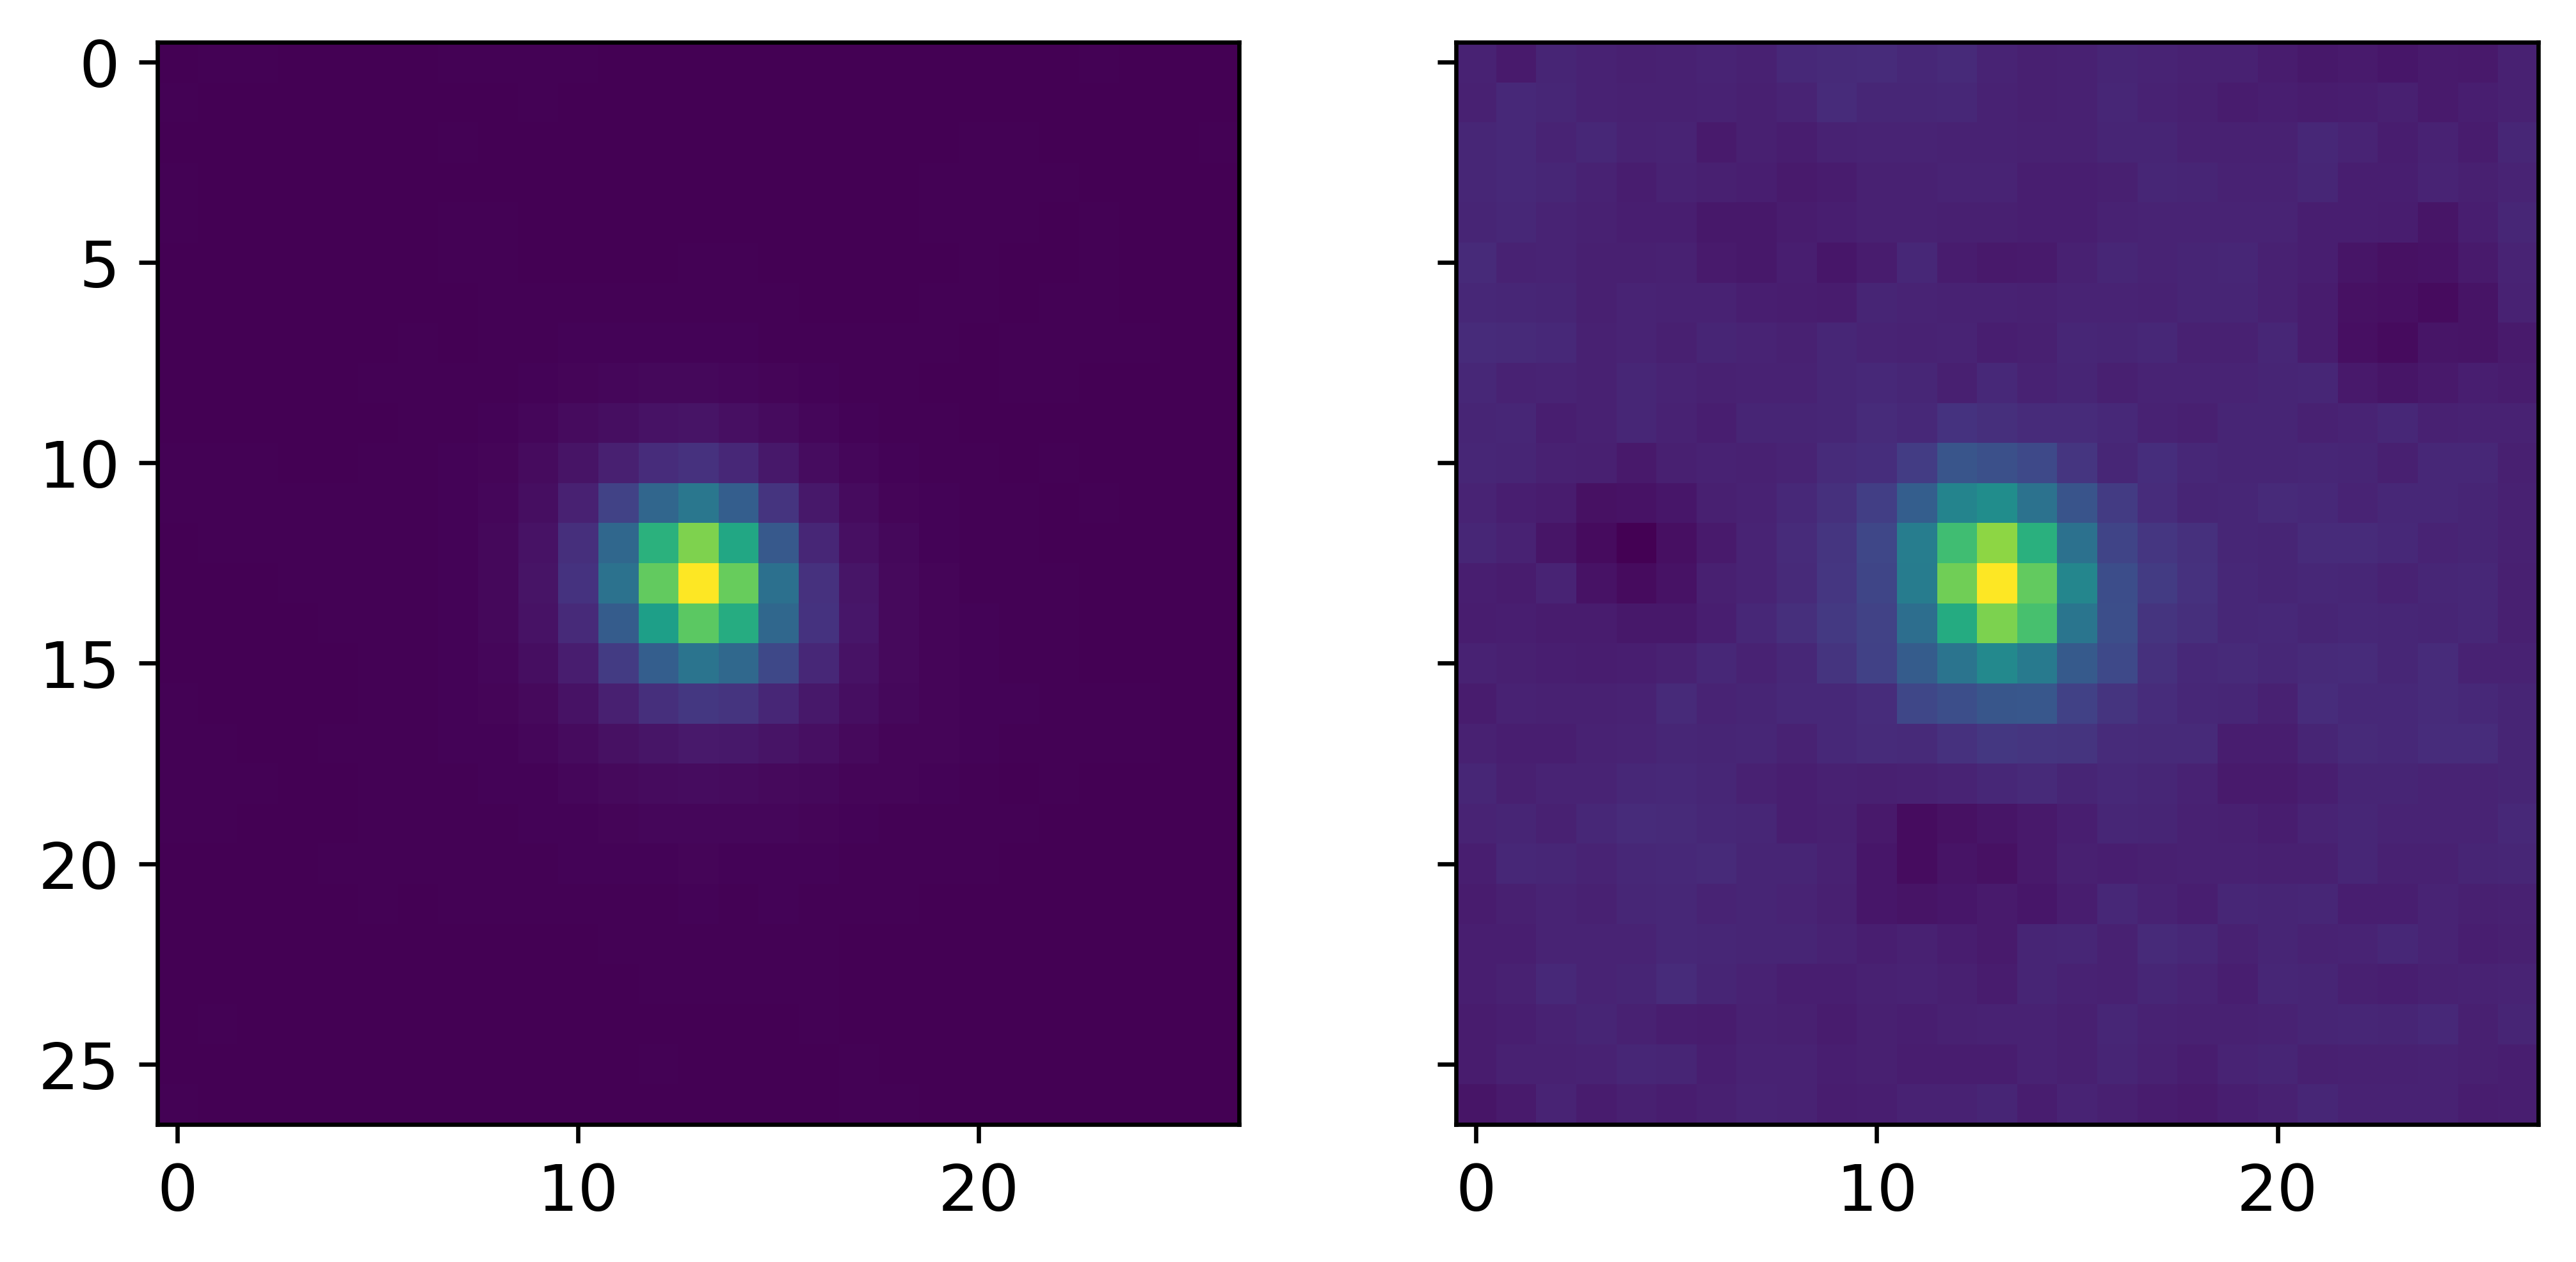

In [12]:
plt.figure(4)
f, ax = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True)
myPoint = lsstGeom.Point2D(200,300)
myPsf = calexp.getPsf().computeImage(myPoint)
ax[0].imshow(myPsf.getArray())

myPoint = lsstGeom.Point2D(800,800)
myPsf = calexp.getPsf().computeImage(myPoint)
ax[1].imshow(myPsf.getArray())

In [ ]:
plt.figure(5)
display = afwDisplay.Display(frame=5, backend='matplotlib')
display.scale("linear", "zscale")
display.mtv(calexp[500:1500,2500:3000])

In [ ]:
mask = calexp.getMask()
for mask_name, mask_bit in mask.getMaskPlaneDict().items():
    print('{:20}: {}'.format(mask_name, display.getMaskPlaneColor(mask_name)))

In [ ]:
calexp.mask.clearAllMaskPlanes()

In [ ]:
calexp.getMask().getMaskPlaneDict()

In [13]:
calexp.mask.clearMaskPlane(5)
calexp.mask.clearMaskPlane(6)

In [ ]:
plt.figure(6)
display = afwDisplay.Display(frame=5, backend='matplotlib')
display.scale("linear", "zscale")
display.mtv(calexp)

In [14]:
schema = afwTable.SourceTable.makeMinimalSchema()

In [15]:
#create an instance of the source detection config
config = SourceDetectionConfig()
#drill down on the atributes of the config and set them 
config.thresholdType = 'stdev'
config.thresholdValue = 5.0 #we want 5 sigma detection threshold
config.includeThresholdMultiplier = 1 # this scales the threshold value, so that the threshold is thresholdValue*thresholdMultiplyer
config.minPixels = 5 # sources less with fewer than 5 pixels will not be counted as detected sources

Setup three tasks which we will run:
- Source detection
- Source deblending
- Source measurment

In [16]:
srcDetection = SourceDetectionTask(config=config, schema=schema)

In [17]:
sourceDeblendTask   =   SourceDeblendTask(schema=schema) #Can add their own column to schema
measConfig = SingleFrameMeasurementConfig()
#measConfig.plugins.names.add('ext_photometryKron_KronFlux') #New measurment algorithm
sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, config=measConfig)


In [18]:
tab = afwTable.SourceTable.make(schema)


In [19]:
detRes = srcDetection.run(tab, calexp)

In [ ]:
sources = detRes.sources

In [ ]:
#Source deblending
sourceDeblendTask.run(calexp, sources)
#Source measurement
sourceMeasurementTask.run(measCat=sources, exposure=calexp)

<Figure size 4800x4800 with 0 Axes>

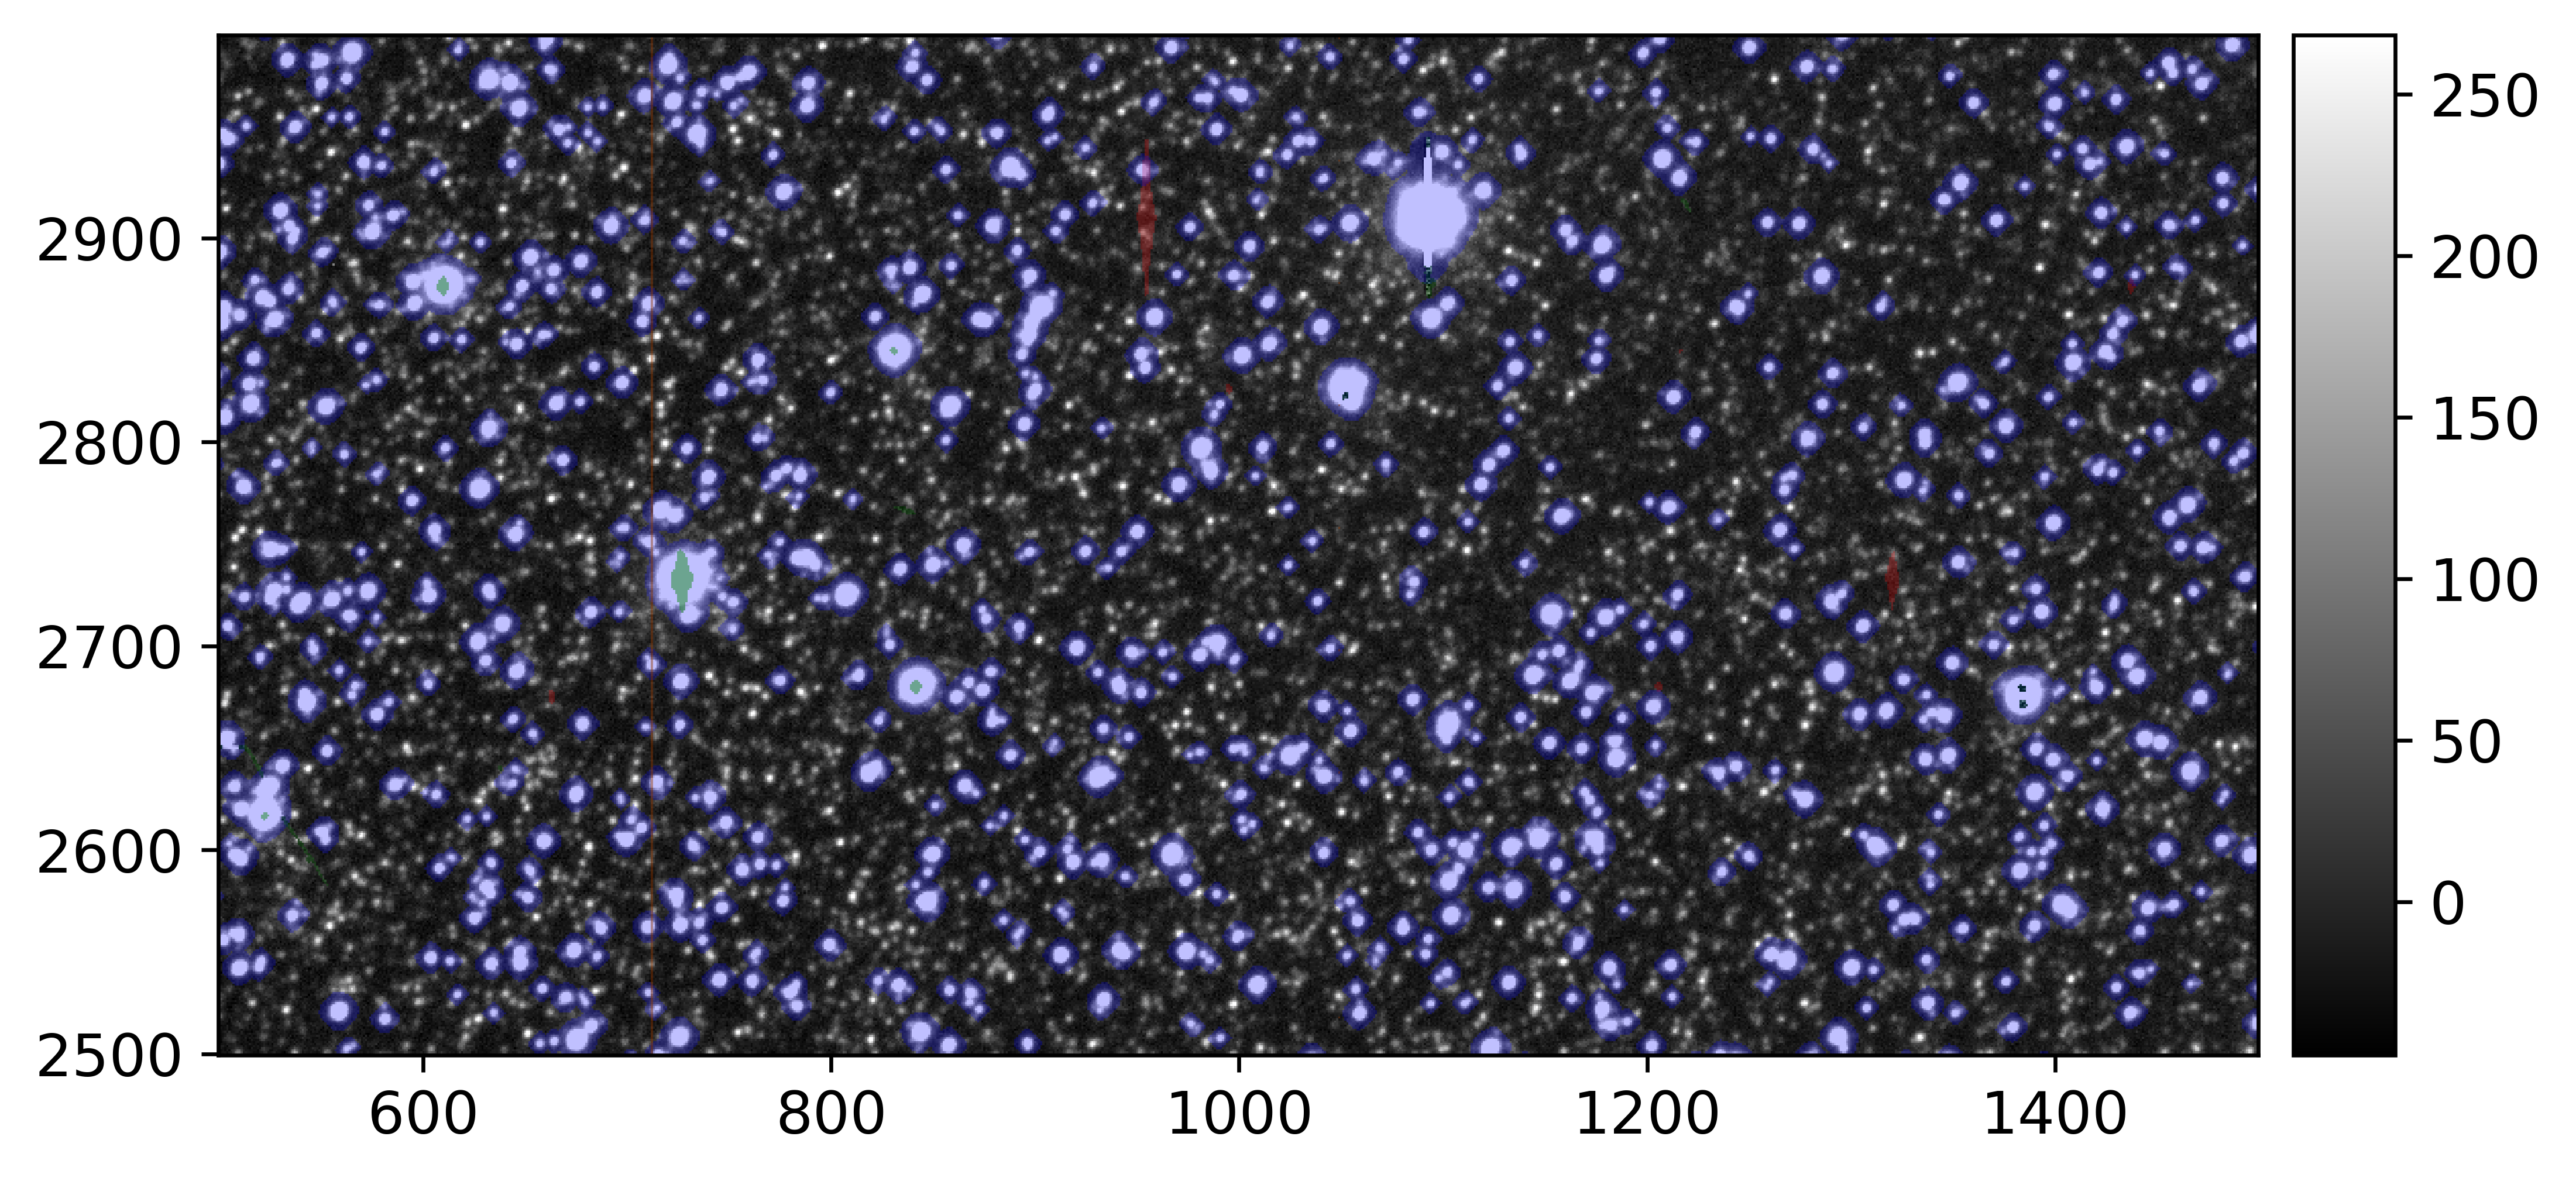

In [22]:
plt.figure(7)
display = afwDisplay.Display(backend='matplotlib')
display.scale("linear", "zscale")
display.mtv(calexp.maskedImage[500:1500,2500:3000])


In [ ]:
fpset = detRes.fpSets.positive
#fps will be a list of the footprints
fps = detRes.fpSets.positive.getFootprints()


In [ ]:
#This will return a rectangle in pixel coordinates of the CCD that the first footprint lies on
fps[0].getRegion()
#center of the footprint in detector coordinates
fps[0].getCentroid()
#the smallest box you could enscribe around the footprint
#not all the pixels in the bounding box strictly belong to the footprint, 
#since the footprint isnt necessarily rectangular
fps[0].getBBox()
#area of the Footprint, not to be confused with the area of the bounding box
fps[0].getArea()
fpset.makeHeavy(calexp.maskedImage)
# we have to redefine fps
hfps = fpset.getFootprints()
hfps[0].isHeavy()

In [ ]:
footprintNr = 60
yind, xind = hfps[footprintNr].spans.indices()
imshape = hfps[footprintNr].spans.unflatten(hfps[footprintNr].getImageArray()).shape
plt.figure(8)
#f, ax = plt.subplots(ncols=1, nrows=1)
#ax[0].imshow( np.array( hfps[footprintNr].spans, dtype=np.int ) )
plt.imshow( hfps[footprintNr].spans.unflatten(hfps[footprintNr].getImageArray()) )

In [ ]:
#First get the key for the deblend_nChild field, and id. We need these to sort on them
nChild_key = sources.getSchema().find('deblend_nChild').key
idKey = sources.getIdKey()

# Sort the catalog on number of children
sources.sort(nChild_key)
# The catalog is sorted low to high, so grab an element towards the end
# Use the nChild key to get the number of children, and the id key to get the parent's ID
# The first few sources with many children are very bright stars that have been shreded
# I took the liberty of finding a nice source that has blended galaxies for you
num_children = sources[-14].get(nChild_key)
parent_id = sources[-14].getId()

# Footprints are stored in the source catalog, we can access them easily
parent_fp = sources[-14].getFootprint()
print('Parent source {} has {} deblended children'.format(parent_id, num_children))

In [ ]:
# deep copy to make it contiguous in memory
peaks = parent_fp.getPeaks().copy(deep=True)
peaks

In [ ]:
# Get the centroid of the parent
# So we can zoom in on it when we display it
parent_x, parent_y = sources[-14].getCentroid()

parent_x = int(parent_x)
parent_y = int(parent_y)

In [ ]:
# Sort the catalog on ID 
# It needs to be sorted on ID so we can use the getChildren method
sources.sort(idKey)
# child_cat is a smaller afwTable that only has the deblended children
child_cat = sources.getChildren(parent_id)

In [ ]:
# credit to ADW for this afwDisplay snippet
plt.figure(9)
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp.maskedImage[parent_x-100:parent_x+100, parent_y-100:parent_y+100])

# We use display buffering to avoid re-drawing the image after each source is plotted
with afw_display.Buffering():
    # loop over child footprints, placing a red plus on their centers
    for s in child_cat:
        afw_display.dot('+', s.getX(), s.getY(), ctype=afwDisplay.RED)
    # loop over peaks, placing an orange circle on their centers    
    for p in parent_fp.getPeaks():
        afw_display.dot('o', p.getIx(), p.getIy(), ctype=afwDisplay.ORANGE, size=4)

In [ ]:
fp_dict = {measRecord.getId(): (measRecord.getParent(), measRecord.getFootprint())
                      for measRecord in sources}

nr_config = NoiseReplacerConfig()
noiseReplacer = NoiseReplacer(nr_config, calexp, fp_dict)

In [ ]:
plt.figure(10)
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp.maskedImage[parent_x-100:parent_x+100, parent_y-100:parent_y+100])

In [ ]:
# we will need the ids of the deblended children so we can insert them
# back into the image one at a time
child_ids = child_cat['id'].tolist()

In [ ]:
fig = plt.figure(11)

ims = []

src_ids = [parent_id] + child_ids #tack on the parent ID to the list

for i in src_ids:
    # replace the ith source using noiseReplacer
    noiseReplacer.insertSource(i)
    # grab a postage stamp centered on the parent object and plot it
    data = calexp.maskedImage[parent_x-100:parent_x+100, parent_y-100:parent_y+100].getImage().array
    im = plt.imshow(data, origin='lower', animated=True, vmin=-100, vmax=100, visible=False)
    # keep a running list of our plotted images so we can make a movie out of them later
    ims.append([im])
    noiseReplacer.removeSource(i)

# the plt.close catches a spurious extra image
plt.close()

# organize our plotted images into an animation
HTML(animation.ArtistAnimation(fig, ims, interval=1000, blit=True,
                                repeat_delay=1000).to_jshtml())
# takes a minute to get going, 

In [ ]:
f, ax = plt.subplots(nrows=3, ncols=3, sharey=True, sharex=True, figsize=(12,8))

for i, a in zip(range(0, 9), ax.flatten()):
    noiseReplacer.insertSource(i) # fill in the argument here
    data = calexp.maskedImage[parent_x-100:parent_x+100, parent_y-100:parent_y+100].getImage().array
    a.imshow(data, origin='lower', vmin=-100, vmax=100)
    noiseReplacer.removeSource(i) # fill in this argument too

plt.tight_layout()

In [ ]:
# first get the length scale of the PSF 
psf = calexp.getPsf()
sigma = psf.computeShape().getDeterminantRadius()


In [ ]:
hfps[60].getPeaks()


In [ ]:
hfps[60].erode(int(2*sigma))
hfps[60].getPeaks()